# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import tools.davinci as dv
import tools.metrics as ms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, dendrogram
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tools.detector import YoloDetector, MoveNetDetector, PoseLandmarkerDetector
from tools.extractor import Extractor
from tools.structures import Skeleton

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

Video Tag  Clip Id                             Labels  Frame Number  \
0  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19532   
1  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19538   
2  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19544   
3  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19550   
4  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19556   

           X         Y      Width     Height  Person Id  
0  41.965200  4.873195  44.216991  94.802684          0  
1  41.564836  4.874640  44.216991  94.802684          0  
2  41.164472  4.876086  44.216991  94.802684          0  
3  40.764108  4.877532  44.216991  94.802684          0  
4  39.646728  5.014136  44.216991  94.802684          0

Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

# Uncomment the line below to extract frames from the videos
# extractor.extract_frames()

### Skeleton Joints Extraction

To extract keypoints, different approaches will be used such as YOLO-Pose, DeepPose and OpenPose. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

In [4]:
EXAMPLE_IMAGE_PATH = "assets/frames/aJKL0ahn1Dk_20.jpg"

#### YOLO-Pose

In [5]:
yolo_detector = YoloDetector("models/yolov8x-pose-p6.pt")

# Uncomment lines below to apply YOLO detector to the frames
# keypoints = yolo_detector.detect_multi(df, "assets/frames")
# yolo_df = pd.concat(keypoints, ignore_index=True)
# yolo_df.to_csv("assets/annotations/yolo_keypoints.csv", index=False)

yolo_df = pd.read_csv("assets/annotations/yolo_keypoints.csv")
yolo_df.head()

nose_X      nose_Y  left_eye_X  left_eye_Y  right_eye_X  right_eye_Y  \
0  803.315979  173.557571  835.515747  148.530548   783.055054   145.369812   
1  804.176758  173.216003  835.653809  147.682251   782.198486   145.796295   
2  805.239990  169.009888  836.457214  143.686768   782.505249   142.022675   
3  805.590393  172.032562  835.968811  146.862885   780.613586   146.146515   
4  787.117676  165.914810  817.990356  138.446503   763.025269   141.949539   

   left_ear_X  left_ear_Y  right_ear_X  right_ear_Y  ...  right_hip_X  \
0  879.411865  173.806686   757.570801   163.862640  ...   695.001770   
1  878.665039  173.041428   754.971069   165.978302  ...   691.973938   
2  877.768127  170.935852   753.729370   164.452728  ...   695.380554   
3  877.941833  173.451324   752.341492   171.449234  ...   690.252319   
4  868.388611  162.747101   740.108887   168.018570  ...          NaN   

   right_hip_Y  left_knee_X  left_knee_Y  right_knee_X  right_knee_Y  \
0   688.964600          NaN          NaN           NaN           NaN   
1   694.487122          NaN          NaN           NaN           NaN   
2   695.014038          NaN          NaN           NaN           NaN   
3   686.663513          NaN          NaN           NaN           NaN   
4          NaN          NaN          NaN           NaN           NaN   

   left_ankle_X  left_ankle_Y  right_ankle_X  right_ankle_Y  
0           NaN           NaN            NaN            NaN  
1           NaN           NaN            NaN            NaN  
2           NaN           NaN            NaN            NaN  
3           NaN           NaN            NaN            NaN  
4           NaN           NaN            NaN            NaN  

[5 rows x 34 columns]


image 1/1 /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_20.jpg: 1280x1088 1 person, 2326.5ms
Speed: 5.3ms preprocess, 2326.5ms inference, 166.5ms postprocess per image at shape (1, 3, 1280, 1088)
Joints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [299.9683532714844, 134.21372985839844]
Left Eye: [329.235107421875, 105.95368957519531]
Right Eye: [278.1248779296875, 110.82818603515625]
Left Ear: [385.02825927734375, 128.86224365234375]
Right Ear: [260.3104248046875, 137.74391174316406]
Left Shoulder: [450.18255615234375, 314.4795837402344]
Right Shoulder: [203.44998168945312, 312.455078125]
Left Elbow: [471.27410888671875, 559.3909912109375]
Right Elbow: [167.0601043701172, 542.5128784179688]
Left Wrist: [450.08892822265625, 542.22265625]
Right Wrist: [68.72410583496094, 555.3009643554688]
Left Hip: [nan, nan]
Right Hip: [nan, nan]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Left Ankle: [nan, nan]
Right Ankle: [nan, nan]


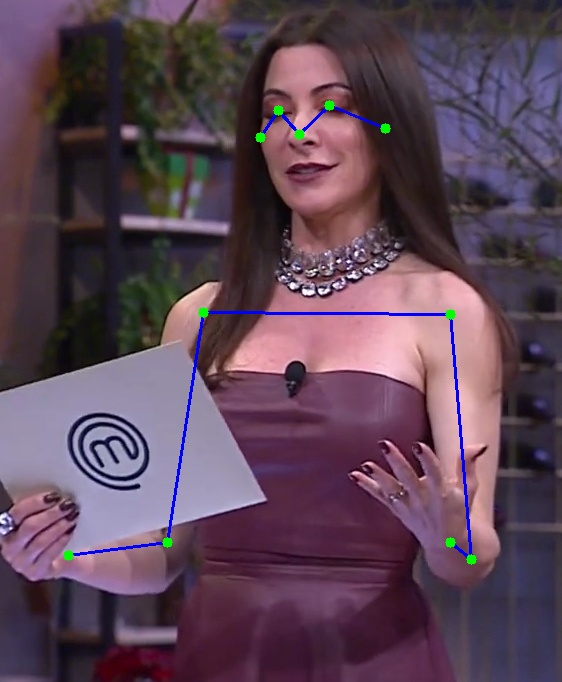

In [6]:
# Example of how a skeleton looks like
result = yolo_detector.detect(EXAMPLE_IMAGE_PATH)
print(result)
dv.draw(result, inline=True)

#### MoveNet

In [7]:
movenet_detector = MoveNetDetector("lightning")

# Uncomment lines below to apply MoveNet detector to the frames
# keypoints = movenet_detector.detect_multi(df, "assets/frames")
# movenet_df = pd.concat(keypoints, axis=1, ignore_index=True).T
# movenet_df.to_csv("assets/annotations/movenet_keypoints.csv", index=False)

movenet_df = pd.read_csv("assets/annotations/movenet_keypoints.csv")
movenet_df.head()

nose_X      nose_Y  left_eye_X  left_eye_Y  right_eye_X  right_eye_Y  \
0  798.434601  171.788353  839.572601  151.494362   768.469696   147.664694   
1  799.262924  171.033987  841.061096  151.012831   768.369904   146.848648   
2  797.994690  164.389780  839.317856  145.981822   767.926254   143.066486   
3  797.490158  171.685259  836.839981  149.894757   767.027588   148.734777   
4  786.974945  166.934295  826.663437  144.017833   755.357513   143.959157   

   left_ear_X  left_ear_Y  right_ear_X  right_ear_Y  ...  right_hip_X  \
0  883.934555  177.981251   744.240112   170.097048  ...   683.769531   
1  885.828857  178.007441   743.087616   169.363668  ...   681.658630   
2  881.477203  173.334593   741.144257   165.809784  ...   684.390564   
3  879.818954  173.152846   739.764557   170.265276  ...   680.073471   
4  874.286728  166.885672   728.797226   164.895709  ...   683.938217   

   right_hip_Y  left_knee_X  left_knee_Y  right_knee_X  right_knee_Y  \
0   638.729110          NaN          NaN           NaN           NaN   
1   655.905590          NaN          NaN           NaN           NaN   
2   645.246878          NaN          NaN           NaN           NaN   
3   651.498442          NaN          NaN           NaN           NaN   
4   622.532558          NaN          NaN           NaN           NaN   

   left_ankle_X  left_ankle_Y  right_ankle_X  right_ankle_Y  
0           NaN           NaN            NaN            NaN  
1           NaN           NaN            NaN            NaN  
2           NaN           NaN            NaN            NaN  
3           NaN           NaN            NaN            NaN  
4           NaN           NaN            NaN            NaN  

[5 rows x 34 columns]

Joints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [300.07107388973236, 138.68204253911972]
Left Eye: [329.04135370254517, 104.52940234541893]
Right Eye: [280.23162722587585, 110.43503695726395]
Left Ear: [377.98564088344574, 125.18668955564499]
Right Ear: [269.14154064655304, 136.8840970993042]
Left Shoulder: [455.37445974349976, 306.525195479393]
Right Shoulder: [221.201584815979, 300.07133984565735]
Left Elbow: [472.23012244701385, 564.0544214248657]
Right Elbow: [192.248874604702, 531.2807128429413]
Left Wrist: [455.24924492836, 530.646404504776]
Right Wrist: [nan, nan]
Left Hip: [374.1500076055527, 659.0409162044525]
Right Hip: [245.76050448417664, 646.6400337219238]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Left Ankle: [nan, nan]
Right Ankle: [nan, nan]


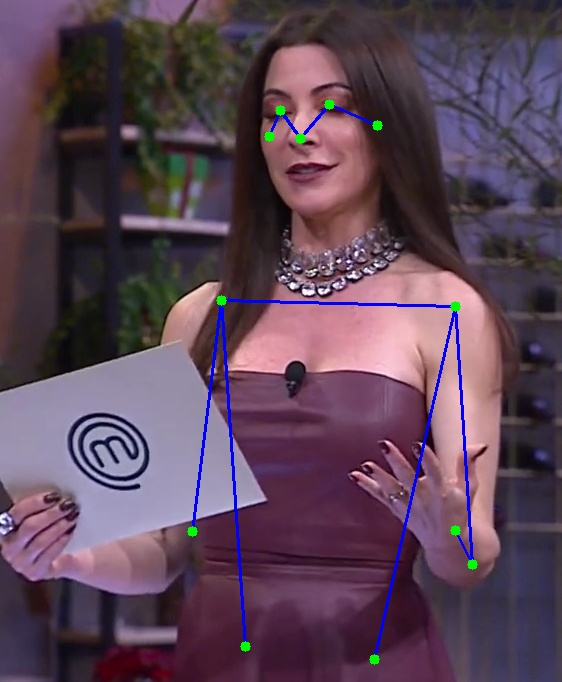

In [8]:
# Example of how a skeleton looks like
result = movenet_detector.detect(EXAMPLE_IMAGE_PATH)
print(result)
dv.draw(result, inline=True)

#### PoseLandmarker (with depth)

In [9]:
poselandmarker_detector = PoseLandmarkerDetector("models/pose_landmarker_full.task")

# Uncomment lines below to apply MoveNet detector to the frames
# keypoints = poselandmarker_detector.detect_multi(df, "assets/frames")
# poselandmarker_df = pd.concat(keypoints, axis=1, ignore_index=True).T
# poselandmarker_df.to_csv("assets/annotations/poselandmarker_keypoints.csv", index=False)

poselandmarker_df = pd.read_csv("assets/annotations/poselandmarker_keypoints.csv")
poselandmarker_df.head()

nose_X      nose_Y  left_eye_X  left_eye_Y  right_eye_X  right_eye_Y  \
0  811.567688  174.096222  841.366501  152.084599   790.503693   148.966928   
1  808.694992  181.475773  840.041809  159.675035   788.186035   155.363202   
2  810.958405  173.270273  838.753967  153.081007   786.259766   148.682613   
3  810.573959  178.200560  840.095444  156.902275   787.346268   151.725183   
4  793.814240  173.647413  819.516754  149.048295   770.276718   151.055446   

   left_ear_X  left_ear_Y  right_ear_X  right_ear_Y  ...  right_hip_X  \
0  869.260254  173.319283   775.243835   164.278178  ...   735.863647   
1  870.816803  180.695872   775.958557   170.310316  ...   742.006912   
2  867.834702  176.679039   768.625946   165.851798  ...   731.772079   
3  870.023499  176.784825   768.461685   167.384090  ...   741.304703   
4  851.129379  166.199799   759.724808   167.180071  ...   760.392303   

   right_hip_Y  left_knee_X  left_knee_Y  right_knee_X  right_knee_Y  \
0   680.167909          NaN          NaN           NaN           NaN   
1   672.522197          NaN          NaN           NaN           NaN   
2   688.078923          NaN          NaN           NaN           NaN   
3   666.833124          NaN          NaN           NaN           NaN   
4   635.200481          NaN          NaN           NaN           NaN   

   left_ankle_X  left_ankle_Y  right_ankle_X  right_ankle_Y  
0           NaN           NaN            NaN            NaN  
1           NaN           NaN            NaN            NaN  
2           NaN           NaN            NaN            NaN  
3           NaN           NaN            NaN            NaN  
4           NaN           NaN            NaN            NaN  

[5 rows x 34 columns]

Joints:
Image: assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [311.0871638059616, 140.17746794223785]
Left Eye: [338.43182837963104, 114.58265495300293]
Right Eye: [289.5495456457138, 117.04326236248016]
Left Ear: [368.9102131128311, 129.09093379974365]
Right Ear: [283.71365761756897, 135.6865372657776]
Left Shoulder: [449.04859924316406, 305.4209282398224]
Right Shoulder: [250.37747418880463, 298.2249798178673]
Left Elbow: [463.65377855300903, 555.0754868984222]
Right Elbow: [184.2573857307434, 474.48881578445435]
Left Wrist: [454.3204176425934, 525.0125887393951]
Right Wrist: [100.3818331360817, 511.81121921539307]
Left Hip: [378.27586591243744, 661.395832657814]
Right Hip: [251.66620194911957, 640.2873568534851]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Left Ankle: [nan, nan]
Right Ankle: [nan, nan]
Joints:
Image: assets/frames/aJKL0ahn1Dk_20.jpg
Nose: [727.8426293894157, 140.17746794223785]
Left Eye: [736.5746704049918, 114.58265495300293]
Right Eye: [666.701655263036, 117.0432623624801

I0000 00:00:1718189237.229034 1221827 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718189237.295769 1222171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718189237.300884 1222171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


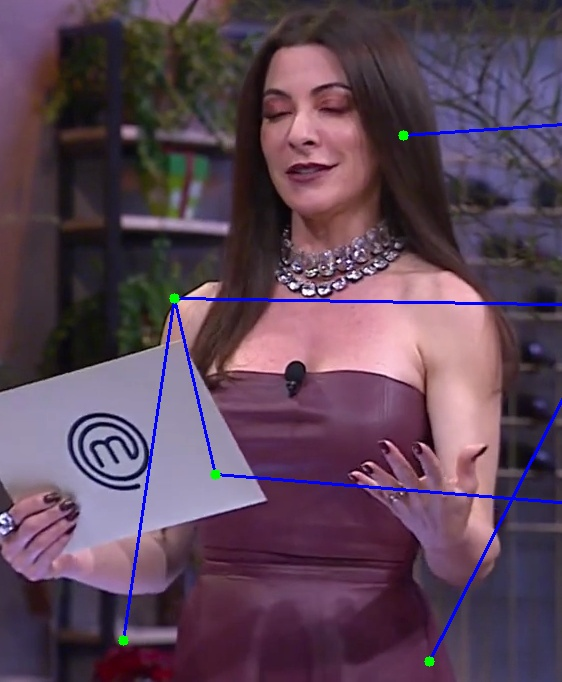

In [10]:
# Example of how a skeleton looks like
result, depths = poselandmarker_detector.detect(EXAMPLE_IMAGE_PATH)
print(result)
aligned_result = ms.align_skeleton(result, depths)
print(aligned_result)
dv.draw(aligned_result, inline=True)

#### Combine all DataFrames

In [11]:
initial_df = pd.read_csv("assets/annotations/annotations.csv")
print("initial_df shape:", initial_df.shape)

yolo_df = pd.read_csv("assets/annotations/yolo_keypoints.csv")
yolo_merged = pd.concat([initial_df, yolo_df], axis=1)
print("yolo_merged shape:", yolo_merged.shape)

movenet_df = pd.read_csv("assets/annotations/movenet_keypoints.csv")
movenet_merged = pd.concat([initial_df, movenet_df], axis=1)
print("movenet_merged shape:", movenet_merged.shape)

poselandmarker_df = pd.read_csv("assets/annotations/poselandmarker_keypoints.csv")
poselandmarker_merged = pd.concat([initial_df, poselandmarker_df], axis=1)
print("poselandmarker_merged shape:", poselandmarker_merged.shape)

# combined_df = pd.concat([yolo_merged, movenet_merged, poselandmarker_merged], axis=0).reset_index(drop=True)
combined_df = pd.concat([poselandmarker_merged], axis=0).reset_index(drop=True)
print("combined_df shape:", combined_df.shape)
combined_df.head()

initial_df shape: (8087, 9)
yolo_merged shape: (8087, 43)
movenet_merged shape: (8087, 43)
poselandmarker_merged shape: (8087, 43)
combined_df shape: (8087, 43)


Video Tag  Clip Id                             Labels  Frame Number  \
0  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19532   
1  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19538   
2  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19544   
3  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19550   
4  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19556   

           X         Y      Width     Height  Person Id      nose_X  ...  \
0  41.965200  4.873195  44.216991  94.802684          0  811.567688  ...   
1  41.564836  4.874640  44.216991  94.802684          0  808.694992  ...   
2  41.164472  4.876086  44.216991  94.802684          0  810.958405  ...   
3  40.764108  4.877532  44.216991  94.802684          0  810.573959  ...   
4  39.646728  5.014136  44.216991  94.802684          0  793.814240  ...   

   right_hip_X  right_hip_Y  left_knee_X  left_knee_Y  right_knee_X  \
0   735.863647   680.167909          NaN          NaN           NaN   
1   742.006912   672.522197          NaN          NaN           NaN   
2   731.772079   688.078923          NaN          NaN           NaN   
3   741.304703   666.833124          NaN          NaN           NaN   
4   760.392303   635.200481          NaN          NaN           NaN   

   right_knee_Y  left_ankle_X  left_ankle_Y  right_ankle_X  right_ankle_Y  
0           NaN           NaN           NaN            NaN            NaN  
1           NaN           NaN           NaN            NaN            NaN  
2           NaN           NaN           NaN            NaN            NaN  
3           NaN           NaN           NaN            NaN            NaN  
4           NaN           NaN           NaN            NaN            NaN  

[5 rows x 43 columns]

### Normalization

#### Skeleton Normalization

At first, not all skeletons, detected on the images, have consistent position relative to the camera. Some people stand and look directly to the camera, some tilted by some unknown angle $\alpha$ around $y$-axis, so only their projection is seen on $xz$ plane; others may stand with their back. For that purpose, it may needed to rotate the skeletons around $y$-axis. However, because there is no depth information in 2D images and only $(x,y)$ coordinates given for skeleton, the <code>PoseLandmarker</code> will be used to estimate $z$ coordinate of each pixel on the image. In other words, the estimated $z$ coordinate will be transferred to the other results from other models. Then detected pixels will be aligned with existing joints coordinates and new Keypoints object with $(x,y,z)$ coordinates will be created as an output for each frame.

According to [Romero Moralis](https://openaccess.thecvf.com/content_CVPR_2019/html/Morais_Learning_Regularity_in_Skeleton_Trajectories_for_Anomaly_Detection_in_Videos_CVPR_2019_paper.html), in 2D image space, $xy$-coordinates alone poorly represent the real location in the scene because the depth is missing. However, the size of a skeleton’s bounding box is correlated with the skeleton’s depth in the scene. To bridge this gap, the skeleton's bounding box can be used (that in our case was already given in dataset) with parameters $f^g = (x^g, y^g, w, h)$ and used to normalize the local components $f^{l,i} = (x^{l,i}, y^{l,i})$. 

In [12]:
norm_skeletons = []

for index, row in combined_df.iterrows():
    start_label = "nose_X"
    row_truncated = row.loc[start_label:]
    box = (row["X"], row["Y"], row["Width"], row["Height"])
    skeleton = Skeleton.from_series(row_truncated)
    norm_skeleton = ms.normalize_skeleton(skeleton, box)
    norm_skeletons.append(norm_skeleton.to_series())

norm_skeletons_df = pd.concat(norm_skeletons, axis=1).T
norm_skeletons_df.shape

# initial_dfs = pd.concat([initial_df] * 3, axis=0).reset_index(drop=True)
initial_dfs = pd.concat([initial_df], axis=0).reset_index(drop=True)
norm_combined_df = pd.concat([initial_dfs, norm_skeletons_df], axis=1)
print(norm_combined_df.shape)
norm_combined_df.head()

(8087, 43)


Video Tag  Clip Id                             Labels  Frame Number  \
0  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19532   
1  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19538   
2  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19544   
3  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19550   
4  aJKL0ahn1Dk        1  [['Happy'], ['Happy'], ['Happy']]         19556   

           X         Y      Width     Height  Person Id     nose_X  ...  \
0  41.965200  4.873195  44.216991  94.802684          0  17.405130  ...   
1  41.564836  4.874640  44.216991  94.802684          0  17.349217  ...   
2  41.164472  4.876086  44.216991  94.802684          0  17.409460  ...   
3  40.764108  4.877532  44.216991  94.802684          0  17.409820  ...   
4  39.646728  5.014136  44.216991  94.802684          0  17.056057  ...   

   right_hip_X  right_hip_Y  left_knee_X  left_knee_Y  right_knee_X  \
0    15.693027     7.123160          NaN          NaN           NaN   
1    15.841016     7.042496          NaN          NaN           NaN   
2    15.618603     7.206577          NaN          NaN           NaN   
3    15.843244     6.982456          NaN          NaN           NaN   
4    16.300195     6.647347          NaN          NaN           NaN   

   right_knee_Y  left_ankle_X  left_ankle_Y  right_ankle_X  right_ankle_Y  
0           NaN           NaN           NaN            NaN            NaN  
1           NaN           NaN           NaN            NaN            NaN  
2           NaN           NaN           NaN            NaN            NaN  
3           NaN           NaN           NaN            NaN            NaN  
4           NaN           NaN           NaN            NaN            NaN  

[5 rows x 43 columns]

#### Data Cleaning

According to [Wei Tang](https://www.mdpi.com/1424-8220/22/11/4245), frames in which body parts were occluded or lost were excluded from further analysis, because the skeletons in these frames could not be detected correctly using the current 2D pose estimation algorithm. The necessary body parts will be determined as torso, left and right hands. The position of head and legs will be ommited.

In [13]:
# Remove all columns that represent legs
columns_drop = norm_combined_df.columns[norm_combined_df.columns.get_loc('right_hip_Y')+1:]
cleaned_df = norm_combined_df.drop(columns=columns_drop)

# Remove rows that have NaN values in all necessary body parts
body_parts = cleaned_df.columns[cleaned_df.columns.get_loc('right_ear_Y')+1:]
cleaned_df = cleaned_df.dropna(subset=body_parts, how='any')
cleaned_df = cleaned_df.reset_index(drop=True)

# For now, later will be changed to "all" and only for eyes and nose
cleaned_df = cleaned_df.dropna(subset=["nose_X", "nose_Y", "left_eye_X", "left_eye_Y",
                                       "right_eye_X", "right_eye_Y", "left_ear_X", "left_ear_Y",
                                       "right_ear_X", "right_ear_Y"], how='any')
cleaned_df = cleaned_df.reset_index(drop=True)

print(cleaned_df.shape)

(3588, 35)


#### Calculate NaN head parameters

#### Segment Normalization

Before clustering, we needs to ensure that all segments have identical size:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [14]:
segments = ms.segmentate(cleaned_df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [ms.normalize_segment(segment) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

norm_segments = ms.segmentate(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 348
Original (first 5): [(0, 49), (50, 56), (57, 65), (66, 74), (75, 88)]
Total number of normalized segments: 348
Normalized (first 5): [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]


## Step 2: Feature Extraction

### Curve Simplification

![Ramer-Douglas_Peucker algorithm visualization](media/rdp.gif)

To extract trajectory features, inspired by [Tomasz Sapiński](https://www.mdpi.com/1099-4300/21/7/646), the curve simplification (CS) algorithm, based on the [Ramer-Douglas-Peucker algorithm](https://rdp.readthedocs.io/en/latest/), will be applied, for 2D joints separately for each segment, that returns a set of key points that are essential for accurately representing the original curve. The algorithm will return the following:
 
- The critical frames in the motion sequence that capture significant changes in the movement.
- The simplified version of the original motion trajectory (data reduction).

The CS algorithm will be called before each feature extraction procedure.

In [15]:
segment = segments[0]

#### Posture

- Head Position and Tilt: The position and tilt of the head can indicate attentiveness, interest, or submission.
- Symmetry in Posture: Asymmetrical postures can indicate discomfort or defensiveness, while symmetrical may indicate confidence.

In [16]:
avg_head_position_x, avg_head_position_y = segment.avg_head_position()
avg_head_tilt = segment.avg_head_tilt()
avg_shoulder_symmetry, avg_hip_symmetry = segment.avg_posture_symmetry()

print("Average head position:", "x =", avg_head_position_x, "y =", avg_head_position_y)
print("Average head tilt:", avg_head_tilt)
print("Average shoulder symmetry:", avg_shoulder_symmetry)
print("Average hip symmetry:", avg_hip_symmetry)

Average head position: x = 16.822180225653607 y = 1.6777002698668069
Average head tilt: 106.83165838283739
Average shoulder symmetry: 4.809098050741477
Average hip symmetry: 3.0772853184188427


#### Movement Dynamics

- Velocity and Acceleration: Speed and acceleration of keypoints, such as hands, can indicate levels of agitation or calmness.
- Jerkiness of Movements: Sudden, jerky movements can indicate fear or anxiety, while smooth movements can indicate calmness or happiness.

In [17]:
avg_velocity_left_hand = segment.avg_velocity(["left_wrist_X", "left_wrist_Y"])
avg_velocity_right_hand = segment.avg_velocity(["right_wrist_X", "right_wrist_Y"])

avg_acceleration_left_hand = segment.avg_acceleration(["left_wrist_X", "left_wrist_Y"])
avg_acceleration_right_hand = segment.avg_acceleration(["right_wrist_X", "right_wrist_Y"])

avg_jerk_left_hand = segment.avg_jerk(["left_wrist_X", "left_wrist_Y"])
avg_jerk_right_hand = segment.avg_jerk(["right_wrist_X", "right_wrist_Y"])

print("Average velocity left hand:", avg_velocity_left_hand)
print("Average velocity right hand:", avg_velocity_right_hand)
print("Average acceleration left hand:", avg_acceleration_left_hand)
print("Average acceleration right hand:", avg_acceleration_right_hand)
print("Average jerk left hand:", avg_jerk_left_hand)
print("Average jerk right hand:", avg_jerk_right_hand)

Average velocity left hand: 2.4568389998463465
Average velocity right hand: 2.517005242517575
Average acceleration left hand: -0.1091928444376154
Average acceleration right hand: -0.11186689966744778
Average jerk left hand: 0.004853015308338462
Average jerk right hand: 0.004971862207442124


#### Gestures:

- Hand and Arm Positions: Positions and movements of the hands and arms can indicate various emotions, such as openness (arms open) or defensiveness (arms crossed).

In [18]:
avg_left_hand_position, avg_right_hand_position = segment.avg_hands_position()

print("Average left hand position:", avg_left_hand_position)
print("Average right hand position:", avg_right_hand_position)

Average left hand position: (18.98050022898356, 6.039474445812462)
Average right hand position: (12.225931347014834, 5.727417388216083)


#### Inter-Keypoint Distances:

- Distance Between Hands and Body: Indicates openness or self-comforting behaviors.

In [19]:
left_wrist_to_body, right_wrist_to_body = segment.avg_dist_to_body()

print("Average left wrist to body distance:", left_wrist_to_body)
print("Average right wrist to body distance:", right_wrist_to_body)

Average left wrist to body distance: 5.491382721671654
Average right wrist to body distance: 7.197190652760037


#### Emotion Labeling

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a particular emotion. In that case for each segment the number of each emotion will be calculated (e.g. <code>[[Happy, Sad, Happy], [Happy, Happy, Angry]]</code> will be converted to <code>{Happy: 4, Sad: 1, Angry: 1, Fear: 0, ...}</code>).

In [20]:
emotion_count = segment.count_emotions()

print("Emotion count:", emotion_count)

Emotion count: {'Happy': 136, 'Sad': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Anger': 0, 'Neutral': 14}


## Step 3: Clustering

### Prepare data to cluster

In [21]:
features = []

for segment in segments:
    feature = pd.DataFrame(segment.get_features()).T
    features.append(feature)

features_df = pd.concat(features, axis=0).reset_index(drop=True)
print(features_df.shape)
features_df.head()

(348, 19)


Label Torso Angle Head Position X Head Position Y   Head Tilt  \
0    Happy   97.816735        16.82218          1.6777  106.831658   
1     Fear  125.338421        13.41036        1.298234  -25.059992   
2    Happy    4.374149       17.406312        1.607186   -1.727938   
3  Neutral   84.902306         40.8191         0.99235 -138.757844   
4    Happy   58.719418       53.585285        1.165742 -102.349175   

  Left Hand Position X Left Hand Position Y Right Hand Position X  \
0              18.9805             6.039474             12.225931   
1            14.789268             2.658299              12.70064   
2            20.018971             2.969258             15.802469   
3             42.55932             2.789663             40.417838   
4            56.439265             3.508817             54.580311   

  Right Hand Position Y Left Wrist Distance to Body  \
0              5.727417                    5.491383   
1              2.186196                    5.178396   
2              2.727558                    3.293095   
3              2.924133                    5.602709   
4              3.708942                    4.405236   

  Right Wrist Distance to Body Shoulder Symmetry Hip Symmetry  \
0                     7.197191          4.809098     3.077285   
1                     5.565719          2.863355     1.589327   
2                     3.954393          3.735926      2.11389   
3                     7.308201          5.225063     2.904201   
4                     7.872033          4.818338     2.643747   

  Left Hand Velocity Right Hand Velocity Left Hand Acceleration  \
0           2.456839            2.517005              -0.109193   
1           1.393108            3.418193              -0.464369   
2           3.351582            3.683725              -0.957595   
3           2.423849            2.233081               -0.80795   
4           1.482956            1.070262              -0.456294   

  Right Hand Acceleration Left Hand Jerk Right Hand Jerk  
0               -0.111867       0.004853        0.004972  
1               -1.139398        0.15479        0.379799  
2               -1.052493       0.273599        0.300712  
3                -0.74436       0.269317         0.24812  
4               -0.329311       0.140398        0.101327

### Analyze the initial labels

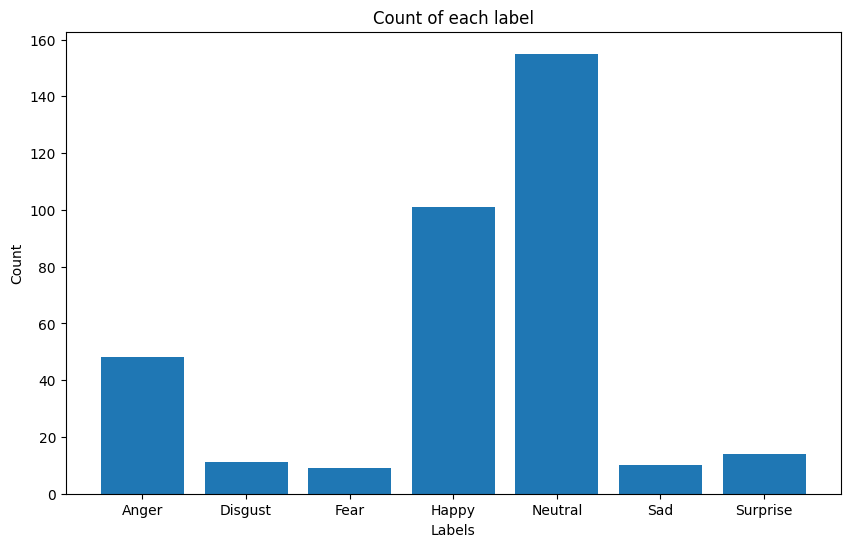

In [22]:
def plot_label_counts(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Count of each label')
    plt.show()

plot_label_counts(features_df["Label"])

### Hierarchical Clustering

Silhouette Score: 0.4966701601934961
Davies-Bouldin Index: 0.57586627823093


/var/folders/tl/5v6l8f8x0_q8pv7_w_s0cxgh0000gn/T/ipykernel_17041/1968636754.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(data.mean())


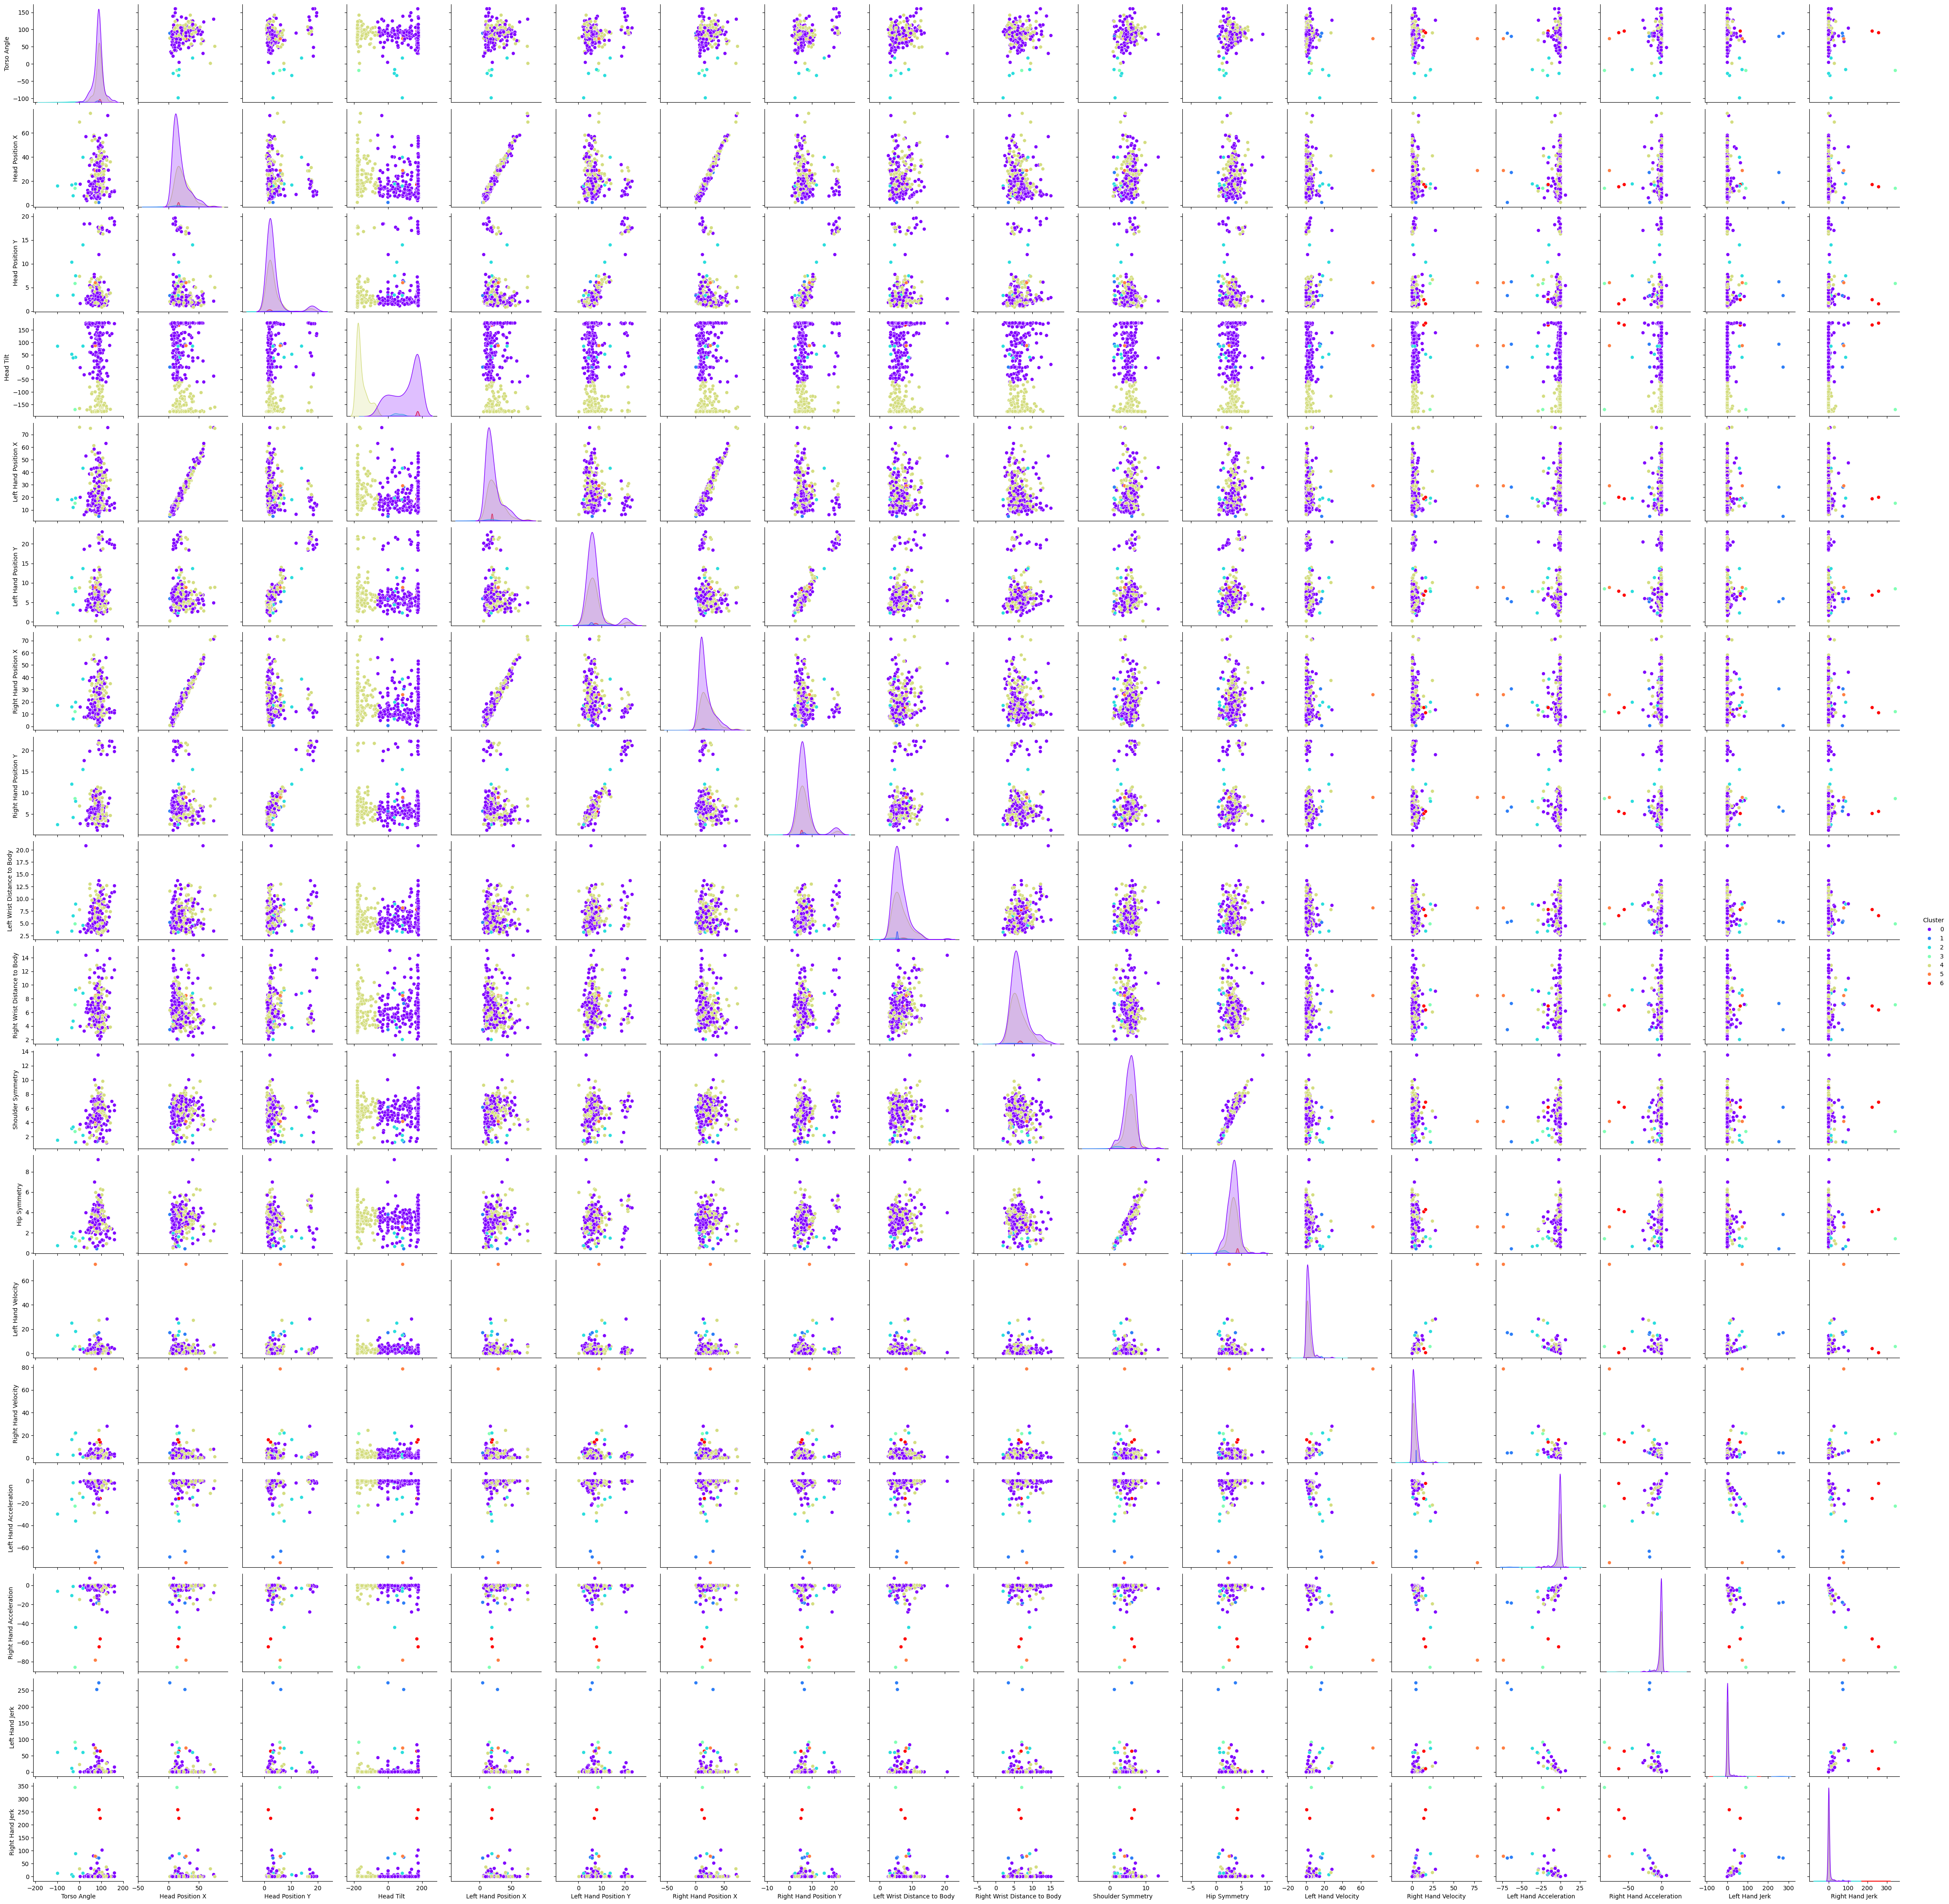

In [23]:
data = features_df.drop(columns=['Label'])
data = data.fillna(data.mean())

cluster = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='average')
cluster_labels = cluster.fit_predict(data)

data['Cluster'] = cluster_labels

# Silhouette Score
silhouette_avg = silhouette_score(data, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(data, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')

sns.pairplot(data, hue='Cluster', palette='rainbow')
plt.show()

Adjusted Rand Index: 0.014583196071382696
Normalized Mutual Information: 0.04678598466815931


<Axes: >

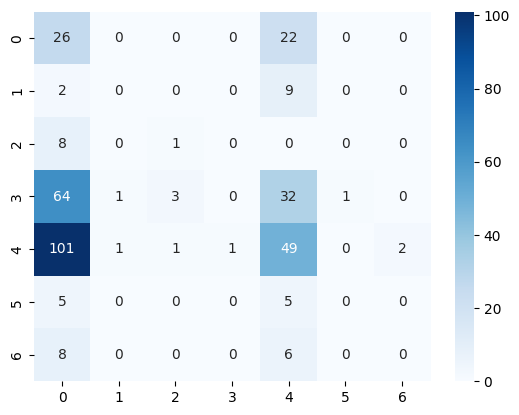

In [24]:
# Assuming features_df['Emotion'] contains the pre-defined clusters
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(features_df['Label'])

# Now, you can compare true_labels with cluster_labels
ari = metrics.adjusted_rand_score(true_labels, cluster_labels)
nmi = metrics.normalized_mutual_info_score(true_labels, cluster_labels)

print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')

cm = confusion_matrix(true_labels, cluster_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

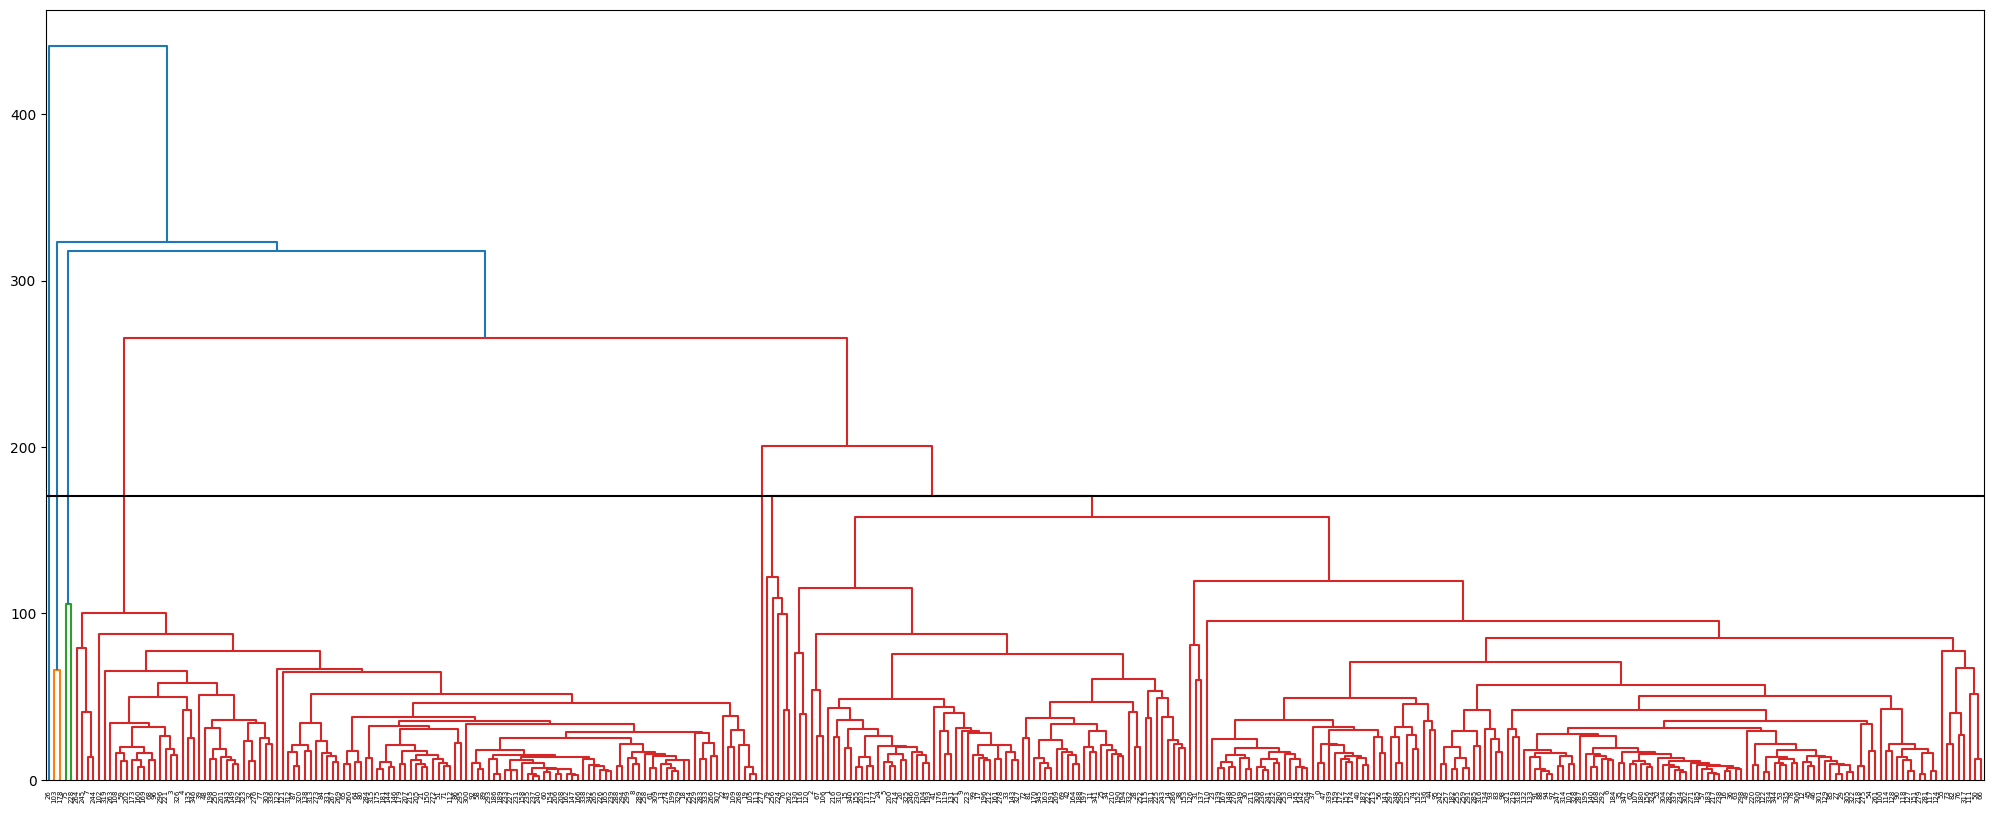

In [25]:
names = features_df['Label']
X = features_df.drop(['Label'],axis=1)
Z = hierarchy.linkage(X.values, 'average')

k = 7
clusters = fcluster(Z, k, criterion='maxclust')
features_df['Cluster'] = clusters

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
max_d = Z[-(k-1), 2]
plt.axhline(y=max_d, c='k')
plt.show()

### Clusters Evaluation

In [26]:
print("Correlations:")

for column in data.columns[:-1]:
    correlation = data[column].corr(data['Cluster'])
    print(f"{column} and Clusters is {correlation}")

Correlations:
Torso Angle and Clusters is 0.036251333688233175
Head Position X and Clusters is 0.18194700417373286
Head Position Y and Clusters is -0.007240167954576935
Head Tilt and Clusters is -0.8443959064126052
Left Hand Position X and Clusters is 0.14969707605426608
Left Hand Position Y and Clusters is 0.012751606415573812
Right Hand Position X and Clusters is 0.14319908945116464
Right Hand Position Y and Clusters is -0.0032368255717242674
Left Wrist Distance to Body and Clusters is 0.03686104609899321
Right Wrist Distance to Body and Clusters is -0.043773334745730266
Shoulder Symmetry and Clusters is 0.025790781588500566
Hip Symmetry and Clusters is 0.05445178417228894
Left Hand Velocity and Clusters is 0.04241736614783118
Right Hand Velocity and Clusters is 0.08647403255836651
Left Hand Acceleration and Clusters is -0.04926786017838595
Right Hand Acceleration and Clusters is -0.14883380547534983
Left Hand Jerk and Clusters is 0.011363871754948416
Right Hand Jerk and Clusters is 

## Step 4: Classification

### Support Vector Machines (SVM)

According to [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/svm.html), SVM will be useful in classification problem in high dimensional spaces and still effective if number of dimensions is higher than number of samples. In addition, it is fast and memory efficient. Also, it can be used in datasets where each class is unequally represented by manually adjusting weights, suggested by [Hengtao Tantai](https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75).

X_train: (278, 19) X_test: (70, 19)
Accuracy: 0.21


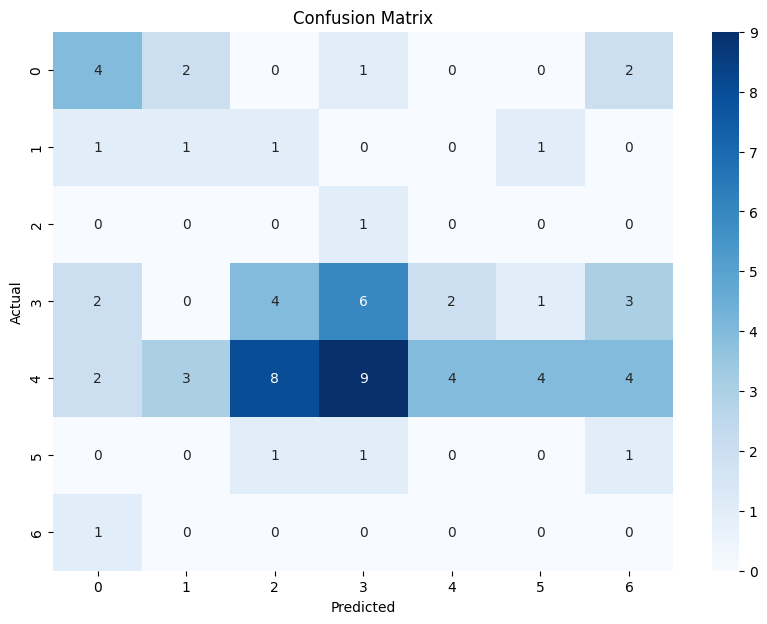

In [48]:
scaler = StandardScaler()

X = features_df.drop(['Label'], axis=1)
y = features_df['Label']
labels = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='linear', C=1, class_weight="balanced")
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()